Базовые алгоритмы для задачи детекции сгенерированных новостных статей

In [3]:
from utils_create_news import try_load, save_s3
from transformers import pipeline
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from minio import Minio

from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    precision_score,
    accuracy_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    f1_score
)


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import os

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

# 0. Инициализация

In [7]:
AWS_ACCESS_KEY_ID_2 = os.getenv('AWS_ACCESS_KEY_ID_2')
AWS_SECRET_ACCESS_KEY_2 = os.getenv('AWS_SECRET_ACCESS_KEY_2')

PATH = '/Users/dan/git_repo/graduate/'

client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=AWS_ACCESS_KEY_ID_2,
    secret_key=AWS_SECRET_ACCESS_KEY_2,
    secure=True
)

In [5]:
# Загрузим модель
classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [8]:
# Скачаем тестовый датасет
test_data_embed = try_load(
    file_path=PATH+'data/',
    file_name='test_data_embed.pkl',
    client_s3=client_s3
    )

test_data_embed = test_data_embed[[
    'key',	'describ',	'paper',	'generated_flg',	'augment_data',	'cut_news'
]]

Load pdf from s3: original news
Load pdf from s3: original news


In [ ]:
def weighted_accuracy(y_true, y_pred):
    "Функция для оценки взвешанной точности (weighted accuracy)"
    classes = np.unique(y_true)
    weights = np.array([np.sum(y_true == c) for c in classes]) / len(y_true)
    acc_per_class = [accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in classes]
    return np.sum(weights * acc_per_class)

# 1. BART Zero-Shot-Classifier: Базовый алгоритм версия 1

In [48]:
# Пример работы над единиичными текстами
candidate_labels = ['Newspaper written by AI LLM Model', 'Newspaper written by human']

for _ in range(5):
  i = random.randint(0, len(x)-1)
  sequence_to_classify = test_data_embed.loc[i, 'paper']
  lable = int(test_data_embed.loc[i, 'generated_flg'])
  describ = test_data_embed.loc[i, 'describ']

  result = classifier(sequence_to_classify, candidate_labels, multi_label=False)
  score = result['scores'][0] if result['labels'][0] == 'Newspaper written by AI LLM Model' else result['scores'][1]

  print(f'lable: {lable}. AI text Score: {score:.3f}. {describ}')

lable: 1. AI text Score: 0.318. guardian_rw_dsv3_5
lable: 0. AI text Score: 0.455. guardian_orig
lable: 0. AI text Score: 0.395. nyt_orig
lable: 1. AI text Score: 0.138. nyt_rw_dsv3_2
lable: 0. AI text Score: 0.305. guardian_orig


In [ ]:
# Список для хранения скоров
resilt_array = list()

for idx in tqdm(range(len(test_data_embed))):

  # Вытащим статью и получим предсказание модели
  sequence_to_classify = test_data_embed.loc[idx, 'paper']

  result = classifier(sequence_to_classify, candidate_labels, multi_label=False)
  score = result['scores'][0] if result['labels'][0] == 'Newspaper written by AI LLM Model' else result['scores'][1]

  resilt_array.append(score)


test_data_embed['ai_score_v1'] = resilt_array

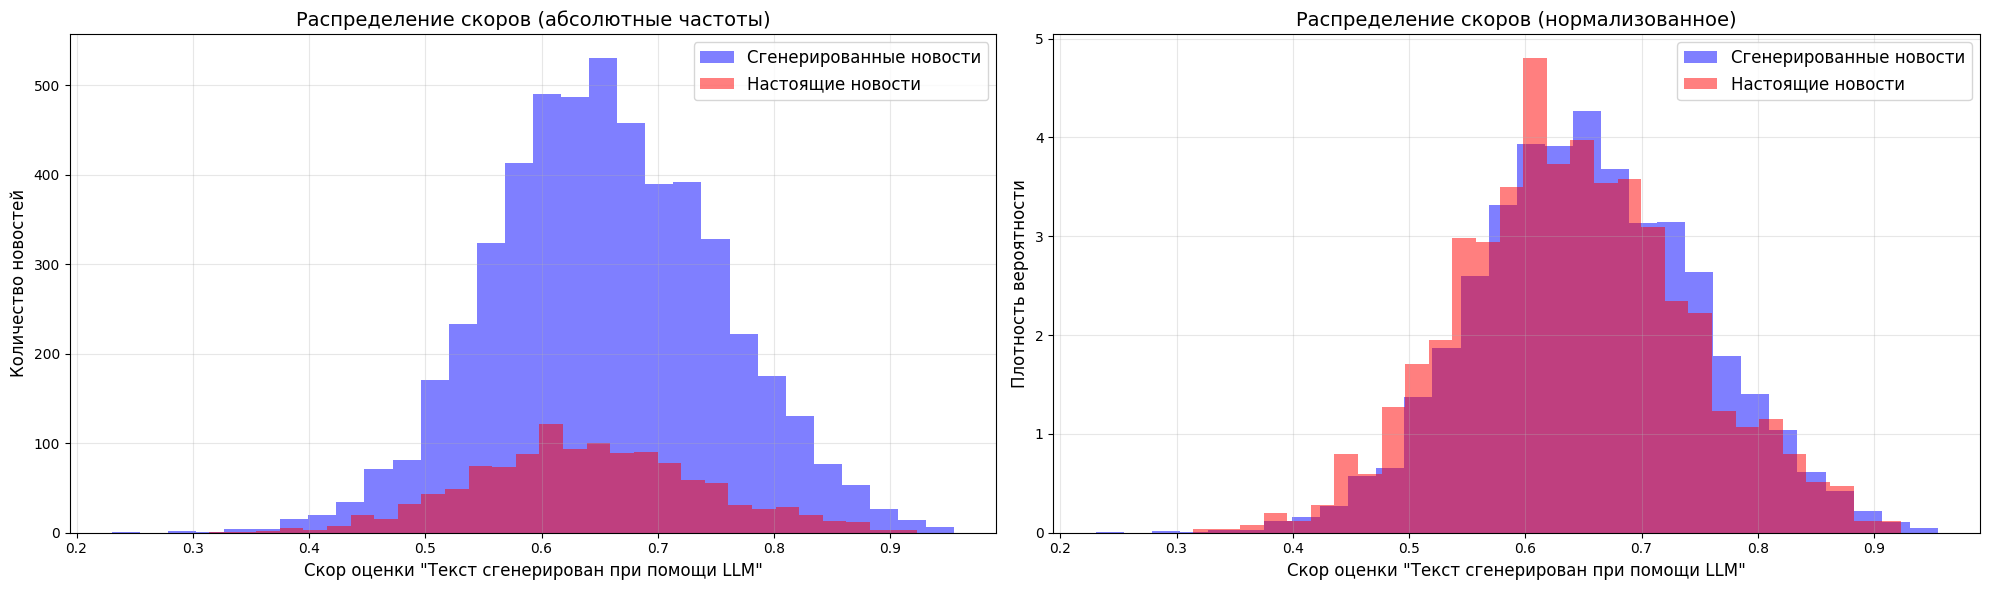

In [168]:
# Подготовим данные для графика
result_gen = test_data_embed[test_data_embed['generated_flg']==1][['ai_score_v1']]
result_orig = test_data_embed[test_data_embed['generated_flg']==0][['ai_score_v1']]

# График
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

result_gen['ai_score_v1'].hist(bins=30,
                           alpha=0.5,
                           color='blue',
                           label='Сгенерированные новости')

result_orig['ai_score_v1'].hist(bins=30,
                             alpha=0.5,
                             color='red',
                             label='Настоящие новости')

plt.title('Распределение скоров (абсолютные частоты)', fontsize=14)
plt.xlabel('Скор оценки "Текст сгенерирован при помощи LLM"', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

result_gen['ai_score_v1'].hist(bins=30,
                           alpha=0.5,
                           color='blue',
                           label='Сгенерированные новости',
                           density=True)

result_orig['ai_score_v1'].hist(bins=30,
                             alpha=0.5,
                             color='red',
                             label='Настоящие новости',
                             density=True)

plt.title('Распределение скоров (нормализованное)', fontsize=14)
plt.xlabel('Скор оценки "Текст сгенерирован при помощи LLM"', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [179]:
print(f"Доля сгенерированных текстов: {test_data_embed['generated_flg'].mean():.2f}\n")

# trashhold определим по precision recall curve
precision, recall, thresholds = precision_recall_curve(test_data_embed['generated_flg'], test_data_embed['ai_score_v1'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # F1 для каждого порога
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог (по PR-кривой): {best_thresh:.2f}\n")

test_data_embed['y_pred_v1'] = test_data_embed['ai_score_v1'].apply(lambda x: 1 if x >= best_thresh else 0)

# Метрики
print(f"ROC-AUC: {roc_auc_score(test_data_embed['generated_flg'], test_data_embed['ai_score_v1']):.2f}")
print(f"Average_precision_score: {average_precision_score(test_data_embed['generated_flg'], test_data_embed['ai_score_v1']):.2f}\n")

print(f"Accuracy W: {weighted_accuracy(test_data_embed['generated_flg'], test_data_embed['y_pred_v1']):.2f}")
print(f"Precision W: {precision_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1'], average='weighted', zero_division=np.nan):.2f}")
print(f"Recall W: {recall_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1'], average='weighted', zero_division=np.nan):.2f}")
print(f"F1-score W: {f1_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1'], average='weighted', zero_division=np.nan):.2f}\n")

print(f"Precision: {precision_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1']):.2f}")
print(f"Recall: {recall_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1']):.2f}")
print(f"F1-score: {f1_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v1']):.2f}")

Доля сгенерированных текстов: 0.81

Лучший порог (по PR-кривой): 0.23

ROC-AUC: 0.54
Average_precision_score: 0.83

Accuracy W: 0.81
Precision W: 0.81
Recall W: 0.81
F1-score W: 0.72

Precision: 0.81
Recall: 1.00
F1-score: 0.89


# 2. BART Zero-Shot-Classifier: Базовый алгоритм версия 2

In [ ]:
# Метки и шаблон
candidate_labels = ['AI-generated', 'Human-written']
hypothesis_template = "This text was {}."

resilt_array_2 = []

for idx in tqdm(range(len(test_data_embed))):

  # Вытащим статью и получим предсказание модели
  sequence_to_classify = test_data_embed.loc[idx, 'paper']

  result = classifier(sequence_to_classify, candidate_labels, hypothesis_template=hypothesis_template)
  score = result['scores'][0] if result['labels'][0] == 'AI-generated' else result['scores'][1]

  resilt_array_2.append(score)

test_data_embed['ai_score_v2'] = resilt_array_2

test_data_embed['ai_score_v2'] = 1 - test_data_embed['ai_score_v2']

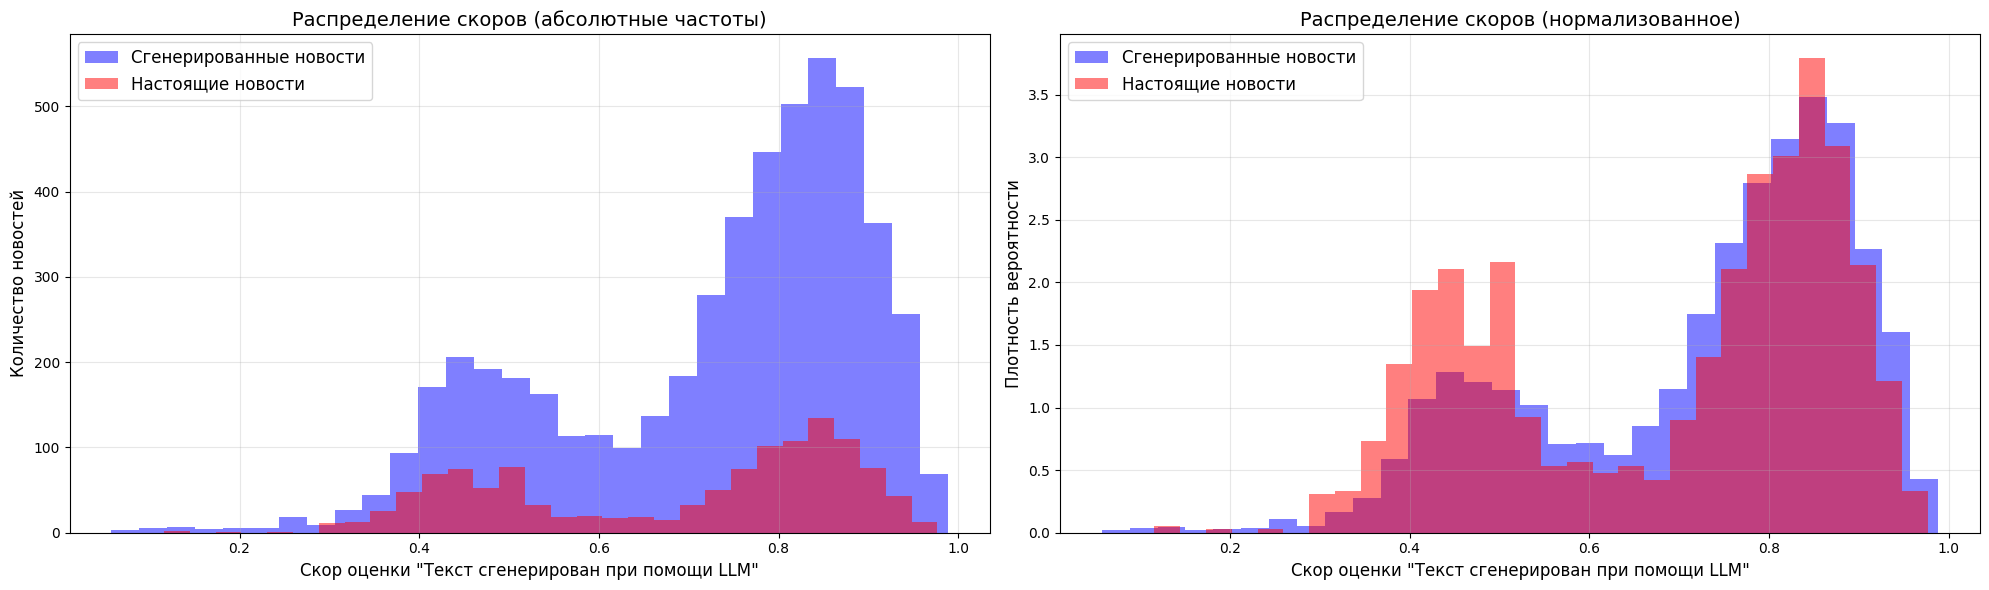

In [169]:
# Подготовим данные для графика
result_gen = test_data_embed[test_data_embed['generated_flg']==1][['ai_score_v2']]
result_orig = test_data_embed[test_data_embed['generated_flg']==0][['ai_score_v2']]

# График
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

result_gen['ai_score_v2'].hist(bins=30,
                           alpha=0.5,
                           color='blue',
                           label='Сгенерированные новости')

result_orig['ai_score_v2'].hist(bins=30,
                             alpha=0.5,
                             color='red',
                             label='Настоящие новости')

plt.title('Распределение скоров (абсолютные частоты)', fontsize=14)
plt.xlabel('Скор оценки "Текст сгенерирован при помощи LLM"', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

result_gen['ai_score_v2'].hist(bins=30,
                           alpha=0.5,
                           color='blue',
                           label='Сгенерированные новости',
                           density=True)

result_orig['ai_score_v2'].hist(bins=30,
                             alpha=0.5,
                             color='red',
                             label='Настоящие новости',
                             density=True)

plt.title('Распределение скоров (нормализованное)', fontsize=14)
plt.xlabel('Скор оценки "Текст сгенерирован при помощи LLM"', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [178]:
# trashhold определим по precision recall curve
precision, recall, thresholds = precision_recall_curve(test_data_embed['generated_flg'], test_data_embed['ai_score_v2'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # F1 для каждого порога
best_thresh_v2 = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог (по PR-кривой): {best_thresh_v2:.2f}\n")

test_data_embed['y_pred_v2'] = test_data_embed['ai_score_v2'].apply(lambda x: 1 if x >= best_thresh_v2 else 0)

# Метрики
print(f"ROC-AUC: {roc_auc_score(test_data_embed['generated_flg'], test_data_embed['ai_score_v2']):.2f}")
print(f"Average_precision_score: {average_precision_score(test_data_embed['generated_flg'], test_data_embed['ai_score_v2']):.2f}\n")

print(f"Accuracy W: {weighted_accuracy(test_data_embed['generated_flg'], test_data_embed['y_pred_v2']):.2f}")
print(f"Precision W: {precision_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2'], average='weighted', zero_division=np.nan):.2f}")
print(f"Recall W: {recall_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2'], average='weighted', zero_division=np.nan):.2f}")
print(f"F1-score W: {f1_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2'], average='weighted', zero_division=np.nan):.2f}\n")

print(f"Precision: {precision_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2']):.2f}")
print(f"Recall: {recall_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2']):.2f}")
print(f"F1-score: {f1_score(test_data_embed['generated_flg'], test_data_embed['y_pred_v2']):.2f}")

Лучший порог (по PR-кривой): 0.06

ROC-AUC: 0.55
Average_precision_score: 0.83

Accuracy W: 0.81
Precision W: 0.81
Recall W: 0.81
F1-score W: 0.72

Precision: 0.81
Recall: 1.00
F1-score: 0.89
